In [199]:
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
from yellowbrick.cluster.elbow import kelbow_visualizer
import numpy as np

In [200]:
caminho_script = 'E:/Coisas/Notas4/upperbag/'
caminho_arquivos = caminho_script + 'csvs/'
caminho_arquivos_raw = caminho_arquivos + 'raw/'
caminho_arquivos_tratados = caminho_arquivos + 'tratado/'

Tratamentos:
- por conta de as quantidades ficarem na primeira linha e o valor da compra na ultima de cada bag, separamos por cliente, fazemos as agregações, depois juntamos
- tiramos os nas de cada um dos dois datasets separados antes de juntar
- tiramos os casos que o cliente tem valor de compra mas nao tem quantidade de itens maior que 0
- tirei a parte de replicar as colunas qtd_itens_comprados e qtd_bags_enviadas da Fernanda

In [201]:
df_fem_sec = pd.read_csv( caminho_arquivos_tratados + 'feminino_secure.csv', encoding='utf-8') # importa

df_fem_sec_vl = df_fem_sec.dropna(subset=['vl_compra'])
df_fem_sec_vl['vl_compra'] = df_fem_sec_vl.apply(lambda row: str(row['vl_compra']).replace('r$', ''), axis=1)
df_fem_sec_vl['vl_compra'] = df_fem_sec_vl.apply(lambda row: row['vl_compra'] if len(row['vl_compra']) < 8 else 0, axis=1)
df_fem_sec_vl = df_fem_sec_vl[df_fem_sec_vl['vl_compra'] != 0]
df_vl = df_fem_sec_vl[['nm_cliente', 'vl_compra']]
df_vl['vl_compra'] = df_vl['vl_compra'].astype('float64')

df_fem_sec_qt = df_fem_sec.dropna(subset=['qtd_itens_comprados', 'qtd_bags_enviadas'])
df_qt = df_fem_sec_qt[['nm_cliente', 'qtd_itens_comprados', 'qtd_bags_enviadas']]
df_qt['qtd_itens_comprados'] = df_qt['qtd_itens_comprados'].astype('int64')
df_qt['qtd_bags_enviadas'] = df_qt['qtd_bags_enviadas'].astype('int64')

print(df_vl.describe())
print(df_qt.describe())

         vl_compra
count  2321.000000
mean    257.567544
std     303.572256
min       0.000000
25%       0.000000
50%     176.390000
75%     394.700000
max    3150.900000
       qtd_itens_comprados  qtd_bags_enviadas
count          2343.000000        2343.000000
mean              2.996586           1.873239
std               3.462251           1.456947
min               0.000000           1.000000
25%               0.000000           1.000000
50%               2.000000           1.000000
75%               4.000000           2.000000
max              37.000000          15.000000


C:\Users\Odete\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning:

Columns (17,18,19,24,25,26,28,29,37,40,41) have mixed types.Specify dtype option on import or set low_memory=False.

C:\Users\Odete\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Odete\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Odete\A

In [204]:
agg_vl = {'vl_compra':['mean']}
df_agg_vl = df_vl.groupby(['nm_cliente']).agg( agg_vl ) # agrega
df_agg_vl_col = df_agg_vl.copy()
df_agg_vl_col.columns = df_agg_vl_col.columns.map('_'.join)
df_agg_vl_col.shape

(1922, 1)

In [205]:
agg_qt = {'qtd_itens_comprados':['mean'], 'qtd_bags_enviadas':['max']}
df_agg_qt = df_qt.groupby(['nm_cliente']).agg( agg_qt ) # agrega
df_agg_qt_col = df_agg_qt.copy()
df_agg_qt_col.columns = df_agg_qt_col.columns.map('_'.join)
df_agg_qt_col.shape

(1938, 2)

In [206]:
df = df_agg_vl_col.join( df_agg_qt_col, on='nm_cliente', how='inner' )

In [213]:
df_filtrado = df[ ((df['vl_compra_mean'] > 0) & (df['qtd_itens_comprados_mean'] > 0)) | ((df['vl_compra_mean'] == 0) & (df['qtd_itens_comprados_mean'] == 0)) ]
df_filtrado.shape

(1269, 3)

In [214]:
fig = px.box(df_filtrado, y=['qtd_itens_comprados_mean'])
fig.show()

In [215]:
#df_filtrado = df_filtrado[df_filtrado['qtd_itens_comprados_mean'] <= 10]
df_filtrado.shape

(1269, 3)

In [216]:
fig = px.box(df_filtrado, y=['vl_compra_mean'])
fig.show()

In [217]:
#df_filtrado = df_filtrado[df_filtrado['vl_compra_mean'] <= 1000]
df_filtrado.shape

(1269, 3)

In [218]:
fig = px.box(df_filtrado, y=['qtd_bags_enviadas_max'])
fig.show()

In [219]:
#df_filtrado = df_filtrado[df_filtrado['qtd_bags_enviadas_max'] <= 3]
df_filtrado.shape

(1269, 3)

In [220]:
data = df_filtrado.to_numpy()
transformer = Normalizer().fit( data )
data_norm = transformer.transform( data ) # nromaliza dados
df_filtrado_norm = pd.DataFrame( data_norm, columns=df_filtrado.columns )

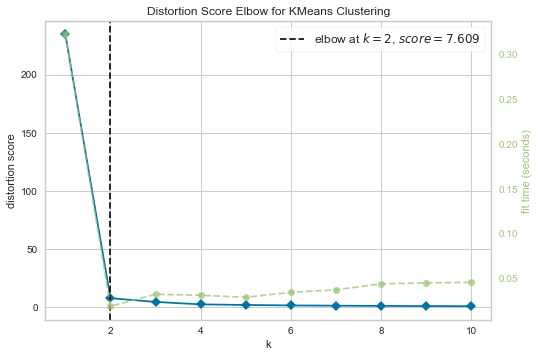

C:\Users\Odete\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [221]:
kelbow_visualizer(KMeans(random_state=4), data_norm, k=(1,11))

In [222]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data_norm)

KMeans(n_clusters=2)

In [223]:
df_filtrado_norm['predict_kmeans'] = df_filtrado_norm.apply(lambda row:kmeans.predict(row.to_numpy().reshape(-1,data_norm.shape[1]))[0],axis=1)
df_filtrado['predict_kmeans'] = df_filtrado.apply(lambda row:kmeans.predict(transformer.transform([row.to_numpy()]).reshape(-1,data_norm.shape[1]))[0],axis=1)

C:\Users\Odete\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [224]:
df_filtrado_norm['predict_kmeans'].value_counts()

0    1138
1     131
Name: predict_kmeans, dtype: int64

In [225]:
fig = px.box(df_filtrado_norm, color='predict_kmeans')
fig.show()

In [226]:
fig = px.box(df_filtrado, y=['qtd_itens_comprados_mean'], color='predict_kmeans')
fig.show()

In [227]:
fig = px.box(df_filtrado, y=['vl_compra_mean'], color='predict_kmeans')
fig.show()

In [228]:
fig = px.box(df_filtrado, y=['qtd_bags_enviadas_max'], color='predict_kmeans')
fig.show()

In [229]:
df_filtrado[['predict_kmeans']].to_csv( caminho_arquivos_tratados + 'predicoes_fem_rfv.csv' )
#df_agre_col_na.truncate(after=-1)[['predicao_kmeans']].to_csv( caminho_arquivos_vazios + 'predicoes_fem.csv', index=False )

In [194]:
df_filtrado

,vl_compra_mean,qtd_itens_comprados_mean,qtd_bags_enviadas_max,predict_kmeans
nm_cliente,,,,
00607cf174858a7c52a34613a555241ee1e395796c5f677c6cbe67e4b12309ee,801.790,2.000000,1,0
007287d2e88e64ed00bc742e2a001a08b1dc1da43e8ec0eb66c1637d2f1d5caf,315.790,5.000000,3,0
008ae18407ec19ba6e398ed2b1180acee3f0546c35ff9d47bb9a416260f4749b,159.000,2.000000,1,0
00a983c7f6b2ced76bd6ce474d4c1e4173e79cce3de5d57f9978ff2d4f2b258b,259.900,1.000000,2,0
00d3cac7e696b15c331dbc5d178ec287dcf0cce047785bada8492e3a024730ca,154.900,3.000000,1,0
...,...,...,...,...
ff3ce0de4578bbf3d3405cc14c7346ad1b33048eecb93915d6e61aaacad49e59,267.990,1.000000,1,0
ff4c6a4736ccf09c8abb2e1727a37e56661c480258665a29be768501598b662e,127.800,1.400000,3,0
ff7e2604cf7c912102fcac8c3d70114463b9b638a1005b51877f92548d071bc3,224.245,3.500000,3,0
